In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

In [2]:
def set_axes_equal(ax):
    """
    Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    """

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

In [18]:
# Load observations
observations = pd.read_csv(f'../data/trajectories/dynamic/observations_adiabatic_global_filtered_1.csv')
len(observations)
rest_positions = np.array([0.10056, -0.10541, 0.10350, 0.09808, -0.20127, 0.10645, 0.09242, -0.31915, 0.09713])
observations.iloc[:, 1:] = observations.iloc[:, 1:] - rest_positions

# Load the control inputs
control_file = '../data/trajectories/dynamic/control_inputs_adiabatic_global_1.csv'
control_inputs = pd.read_csv(control_file)


/var/folders/w1/4wxbkvfn5lzcn6540mz287yw0000gn/T/ipykernel_46076/2033515574.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ys_ik_grouped = observations.groupby("ID", group_keys=False).apply(normalize_trajectory)


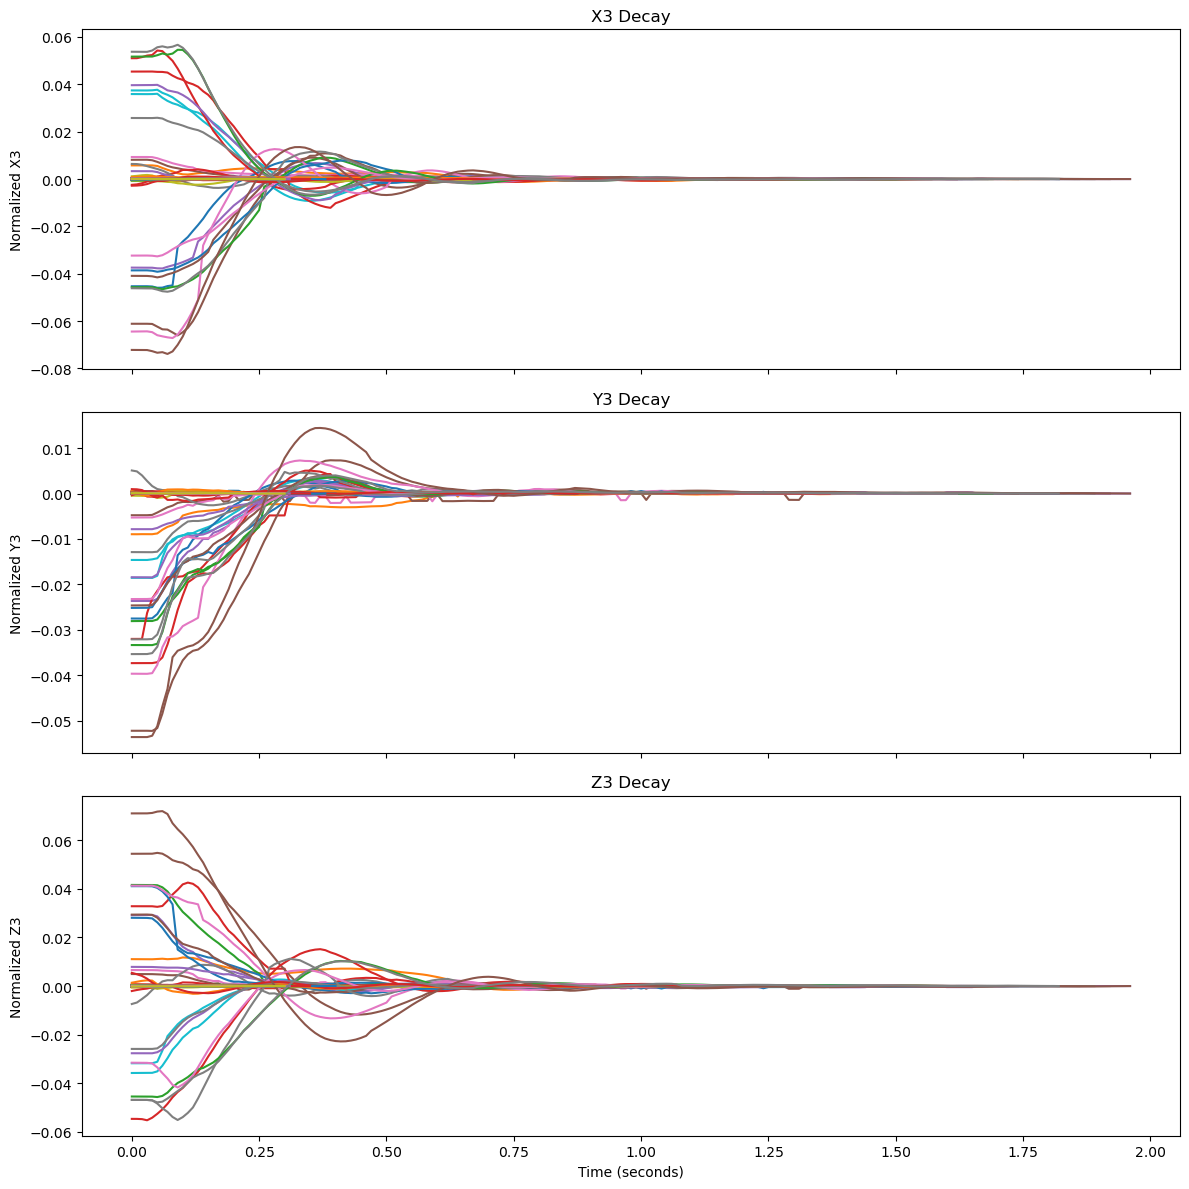

In [19]:
# Prepare the data for plotting
def normalize_trajectory(group):
    # Normalize y-axis so the last value is zero
    group['x3'] = group['x3'] - group['x3'].iloc[-1]
    group['y3'] = group['y3'] - group['y3'].iloc[-1]
    group['z3'] = group['z3'] - group['z3'].iloc[-1]
    # Reset x-axis so it starts at zero
    group['time'] = range(len(group))
    return group

ys_ik_grouped = observations.groupby("ID", group_keys=False).apply(normalize_trajectory)

# Plot the data
fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Plot x3 decays
for traj_id, group in ys_ik_grouped.groupby("ID"):
    axs[0].plot(group['time']/100, group['x3'], label=f"Trajectory {traj_id}")
axs[0].set_title("X3 Decay")
axs[0].set_ylabel("Normalized X3")

# Plot y3 decays
for traj_id, group in ys_ik_grouped.groupby("ID"):
    axs[1].plot(group['time']/100, group['y3'], label=f"Trajectory {traj_id}")
axs[1].set_title("Y3 Decay")
axs[1].set_ylabel("Normalized Y3")

# Plot z3 decays
for traj_id, group in ys_ik_grouped.groupby("ID"):
    axs[2].plot(group['time']/100, group['z3'], label=f"Trajectory {traj_id}")
axs[2].set_title("Z3 Decay")
axs[2].set_ylabel("Normalized Z3")
axs[2].set_xlabel("Time (seconds)")


plt.tight_layout()
plt.show()

Control input 1: (2.143131898507868e-17, 0.2598076211353316, -0.125, -0.2165063509461096, 0.1499999999999999, -0.35)
Control input 2: (0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
Control input 3: (-0.2121320343559642, 0.0647047612756302, 0.051763809020504, -0.1931851652578137, 0.241481456572267, -0.2121320343559642)
Control input 4: (0.35, 0.1499999999999999, -0.2165063509461096, 0.125, -0.2598076211353316, 0.0)
Control input 5: (-6.429395695523604e-17, -0.2598076211353315, 0.1250000000000001, 0.2165063509461096, -0.15, 0.35)
Control input 6: (0.2121320343559642, -0.0647047612756301, -0.051763809020504, 0.1931851652578137, -0.241481456572267, 0.2121320343559643)
Control input 7: (-0.2121320343559643, -0.241481456572267, 0.1931851652578137, 0.051763809020504, 0.0647047612756301, 0.2121320343559642)
Control input 8: (0.2121320343559642, 0.241481456572267, -0.1931851652578136, -0.0517638090205041, -0.0647047612756302, -0.2121320343559642)
Control input 9: (-0.35, -0.1499999999999999, 0.2165063509461096

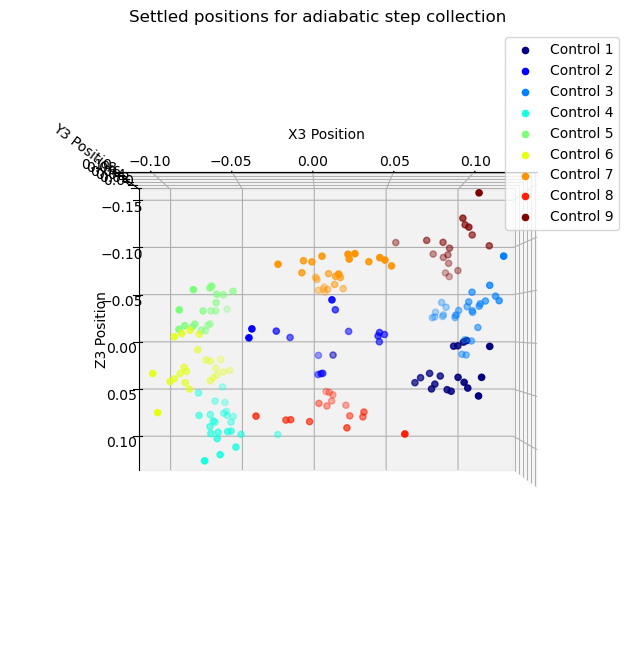

In [20]:
# Extract final settled positions for each trajectory
final_positions = observations.groupby("ID").last()[['x3', 'y3', 'z3']].reset_index()

# Merge observations with control inputs
merged_data = final_positions.merge(control_inputs, on="ID", how="left")

# Drop rows where there was no matching control input
merged_data = merged_data.dropna(subset=["u1", "u2", "u3", "u4", "u5", "u6"])

# Identify unique control input groups
control_columns = ["u1", "u2", "u3", "u4", "u5", "u6"]
merged_data["control_group"] = merged_data[control_columns].apply(tuple, axis=1)

# Get unique control groups and assign colors
unique_controls = merged_data["control_group"].unique()
colors = plt.cm.jet(np.linspace(0, 1, len(unique_controls)))
color_map = dict(zip(unique_controls, colors))

# Plot the 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ct = 1
for control_group in unique_controls:
    subset = merged_data[merged_data["control_group"] == control_group]
    ax.scatter(subset["x3"], subset["y3"], subset["z3"], label=f"Control {ct}", color=color_map[control_group])
    print(f'Control input {ct}: {control_group}')
    ct += 1

ax.set_xlabel("X3 Position")
ax.set_ylabel("Y3 Position")
ax.set_zlabel("Z3 Position")
ax.set_title("Settled positions for adiabatic step collection")
ax.legend()
ax.view_init(elev=180, azim=-90)

plt.show()


/var/folders/w1/4wxbkvfn5lzcn6540mz287yw0000gn/T/ipykernel_46076/3018903084.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shifted_observations = observations.groupby("ID", group_keys=False).apply(shift_trajectory)


Control input 1: (2.143131898507868e-17, 0.2598076211353316, -0.125, -0.2165063509461096, 0.1499999999999999, -0.35)
Control input 2: (0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
Control input 3: (-0.2121320343559642, 0.0647047612756302, 0.051763809020504, -0.1931851652578137, 0.241481456572267, -0.2121320343559642)
Control input 4: (0.35, 0.1499999999999999, -0.2165063509461096, 0.125, -0.2598076211353316, 0.0)
Control input 5: (-6.429395695523604e-17, -0.2598076211353315, 0.1250000000000001, 0.2165063509461096, -0.15, 0.35)
Control input 6: (0.2121320343559642, -0.0647047612756301, -0.051763809020504, 0.1931851652578137, -0.241481456572267, 0.2121320343559643)
Control input 7: (-0.2121320343559643, -0.241481456572267, 0.1931851652578137, 0.051763809020504, 0.0647047612756301, 0.2121320343559642)
Control input 8: (0.2121320343559642, 0.241481456572267, -0.1931851652578136, -0.0517638090205041, -0.0647047612756302, -0.2121320343559642)
Control input 9: (-0.35, -0.1499999999999999, 0.2165063509461096

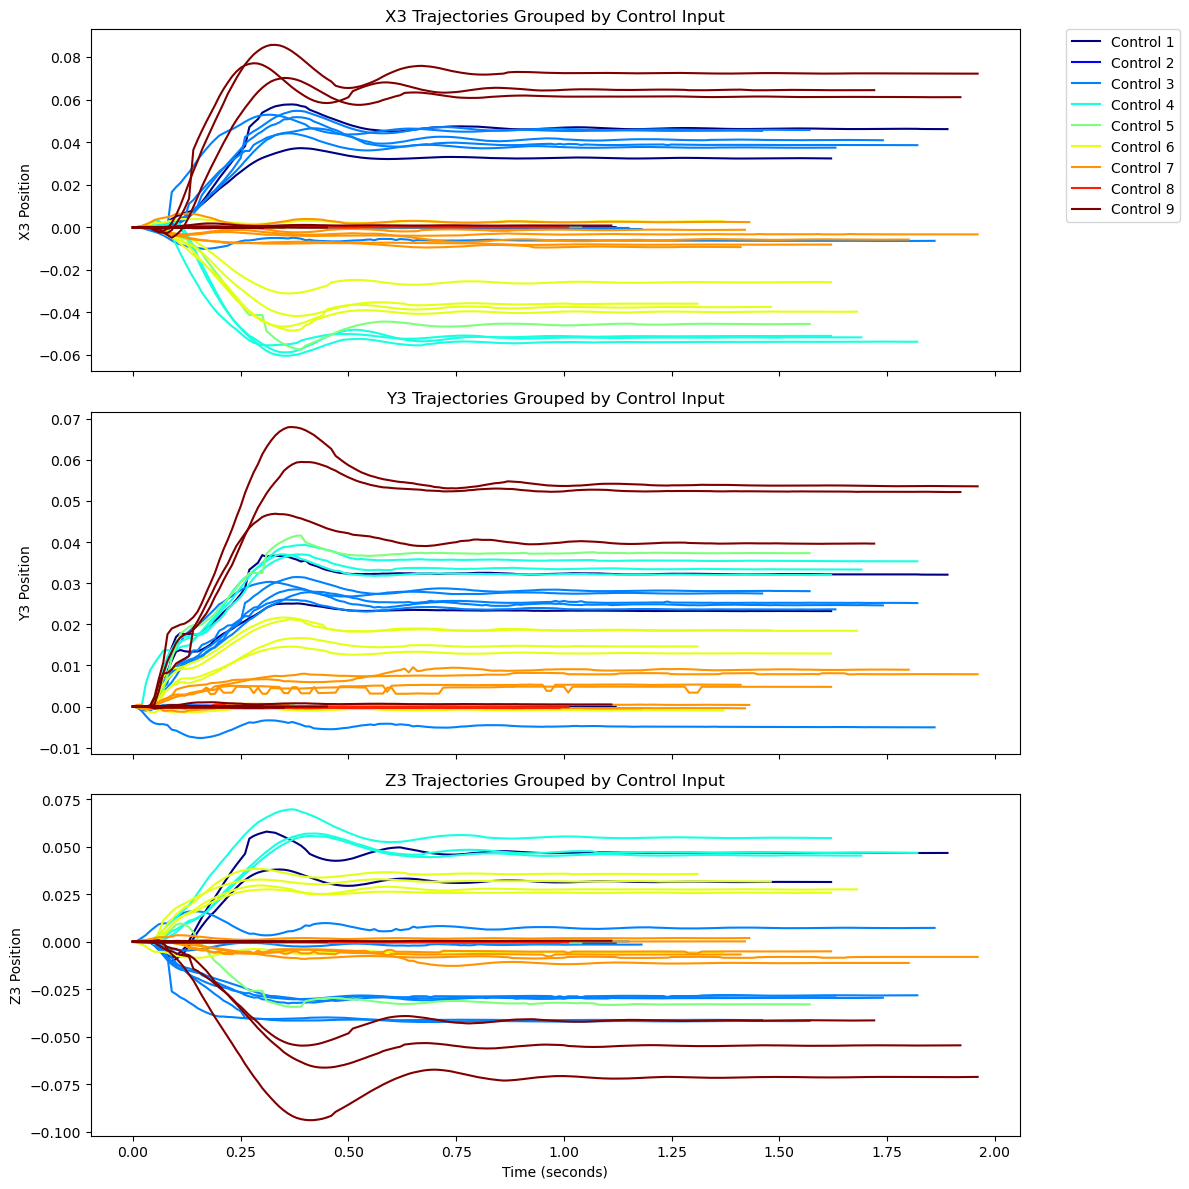

In [21]:
# Prepare the data for plotting (shift each trajectory to start at zero)
def shift_trajectory(group):
    # Reset x-axis so each trajectory starts at zero
    group['time'] = range(len(group))
    
    # Shift each trajectory so the first point is at zero
    group['x3'] = group['x3'] - group['x3'].iloc[0]
    group['y3'] = group['y3'] - group['y3'].iloc[0]
    group['z3'] = group['z3'] - group['z3'].iloc[0]
    
    return group

shifted_observations = observations.groupby("ID", group_keys=False).apply(shift_trajectory)

# Create a new figure for trajectory plots
fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

ct = 1
for control_group in unique_controls:
    subset_ids = merged_data[merged_data["control_group"] == control_group]["ID"]
    subset_trajectories = shifted_observations[shifted_observations["ID"].isin(subset_ids)]
    
    # Get color from the existing mapping
    color = color_map[control_group]

    # Plot x3 trajectory
    for traj_id, traj_group in subset_trajectories.groupby("ID"):
        axs[0].plot(traj_group['time'] / 100, traj_group["x3"], label=f"Control {ct}" if traj_id == subset_ids.iloc[0] else "", color=color)
    
    # Plot y3 trajectory
    for traj_id, traj_group in subset_trajectories.groupby("ID"):
        axs[1].plot(traj_group['time'] / 100, traj_group["y3"], color=color)
    
    # Plot z3 trajectory
    for traj_id, traj_group in subset_trajectories.groupby("ID"):
        axs[2].plot(traj_group['time'] / 100, traj_group["z3"], color=color)

    print(f'Control input {ct}: {control_group}')
    ct += 1

# Set titles and labels
axs[0].set_title("X3 Trajectories Grouped by Control Input")
axs[0].set_ylabel("X3 Position")

axs[1].set_title("Y3 Trajectories Grouped by Control Input")
axs[1].set_ylabel("Y3 Position")

axs[2].set_title("Z3 Trajectories Grouped by Control Input")
axs[2].set_ylabel("Z3 Position")
axs[2].set_xlabel("Time (seconds)")

# Move legend outside the plot
axs[0].legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.)

plt.tight_layout()
plt.show()


Understanding hysteresis with angles and tip positions on trajectories with identical motor commands

In [33]:
rest_positions = np.array([0.10056, -0.10541, 0.10350, 0.09808, -0.20127, 0.10645, 0.09242, -0.31915, 0.09713])
ys_ik = pd.read_csv(f'../data/trajectories/dynamic/observations_controlled_circle_7.0.csv')
ys_ik_2 = pd.read_csv(f'../data/trajectories/dynamic/observations_controlled_circle_7.1.csv')
ys_ik_3 = pd.read_csv(f'../data/trajectories/dynamic/observations_controlled_circle_7.2.csv')

us_1 = pd.read_csv(f'../data/trajectories/dynamic/control_inputs_controlled_14.csv')
us_2 = pd.read_csv(f'../data/trajectories/dynamic/control_inputs_controlled_15.csv')


#ys_ik = ys_ik.drop(columns='ID')

In [ ]:
fig = plt.figure()
fig.scatter(us_1)

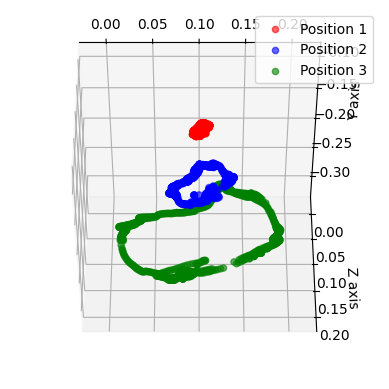

In [10]:
plt.close('all')

# Enable the ipympl backend for interactive plots
#%matplotlib widget

z_dataframes = [ys_ik]
position_colors = ['r', 'b', 'g']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for z_df in z_dataframes:
    x1, y1, z1 = z_df['x1'], z_df['y1'], z_df['z1']
    x2, y2, z2 = z_df['x2'], z_df['y2'], z_df['z2']
    x3, y3, z3 = z_df['x3'], z_df['y3'], z_df['z3']
    ax.scatter(x1, y1, z1, color=position_colors[0], label='Position 1', alpha=0.6)
    ax.scatter(x2, y2, z2, color=position_colors[1], label='Position 2', alpha=0.6)
    ax.scatter(x3, y3, z3, color=position_colors[2], label='Position 3', alpha=0.6)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
# Adjust the view so that y-axis is upwards
ax.view_init(elev=140, azim=-90)
ax.legend()
set_axes_equal(ax)

position variation between trajectories with identical control inputs

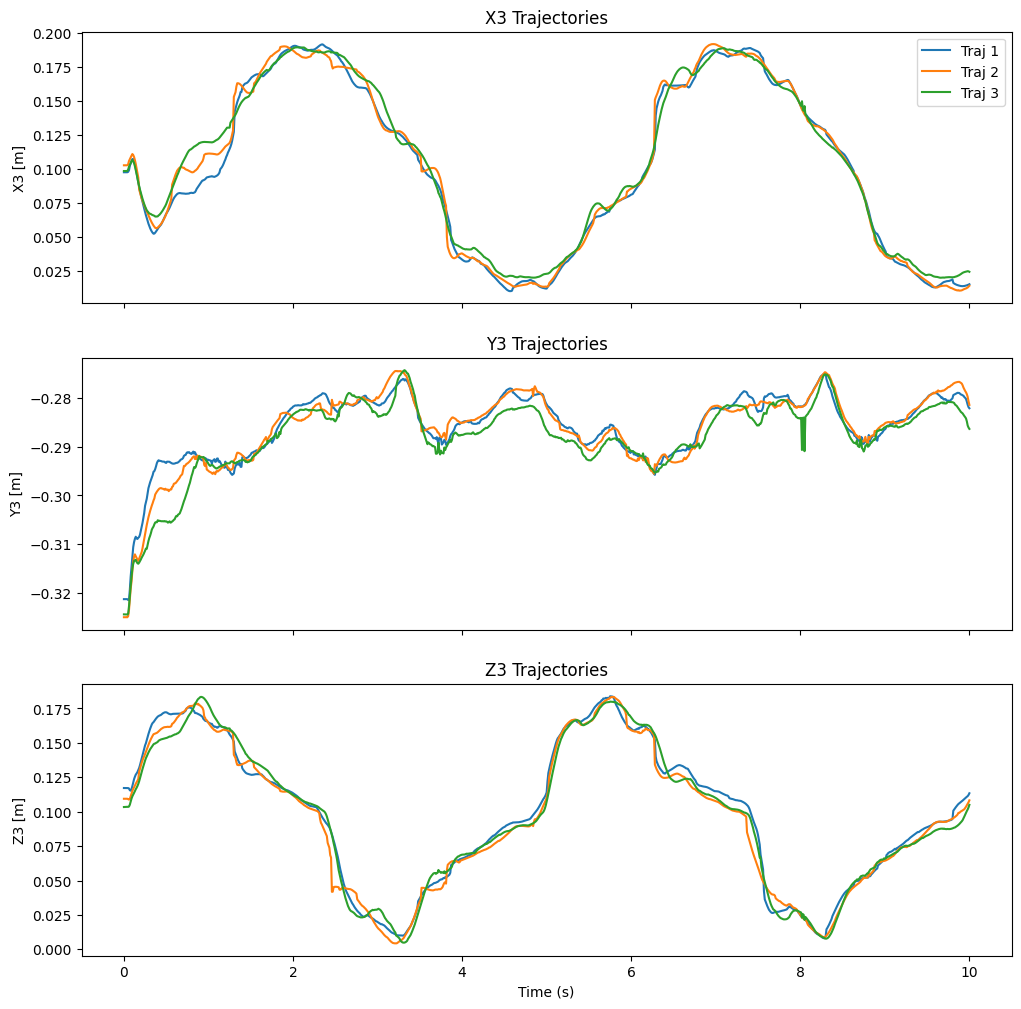

In [31]:
fig, axs = plt.subplots(3, 1, figsize=(12,12), sharex=True)
time = ys_ik['ID']/100 # time in s

# Plot x3
axs[0].plot(time, ys_ik['x3'], label='Traj 1')
axs[0].plot(time, ys_ik_2['x3'], label='Traj 2')
axs[0].plot(time, ys_ik_3['x3'], label='Traj 3')
axs[0].set_title("X3 Trajectories")
axs[0].set_ylabel("X3 [m]")

# Plot y3
axs[1].plot(time, ys_ik['y3'], label='Traj 1')
axs[1].plot(time, ys_ik_2['y3'], label='Traj 2')
axs[1].plot(time, ys_ik_3['y3'], label='Traj 3')
axs[1].set_title("Y3 Trajectories")
axs[1].set_ylabel("Y3 [m]")

# Plot z3
axs[2].plot(time, ys_ik['z3'], label='Traj 1')
axs[2].plot(time, ys_ik_2['z3'], label='Traj 2')
axs[2].plot(time, ys_ik_3['z3'], label='Traj 3')
axs[2].set_title("Z3 Trajectories")
axs[2].set_ylabel("Z3 [m]")
axs[2].set_xlabel("Time (s)")


axs[0].legend(loc="upper right")


angle variation between trajectories with identical control inputs

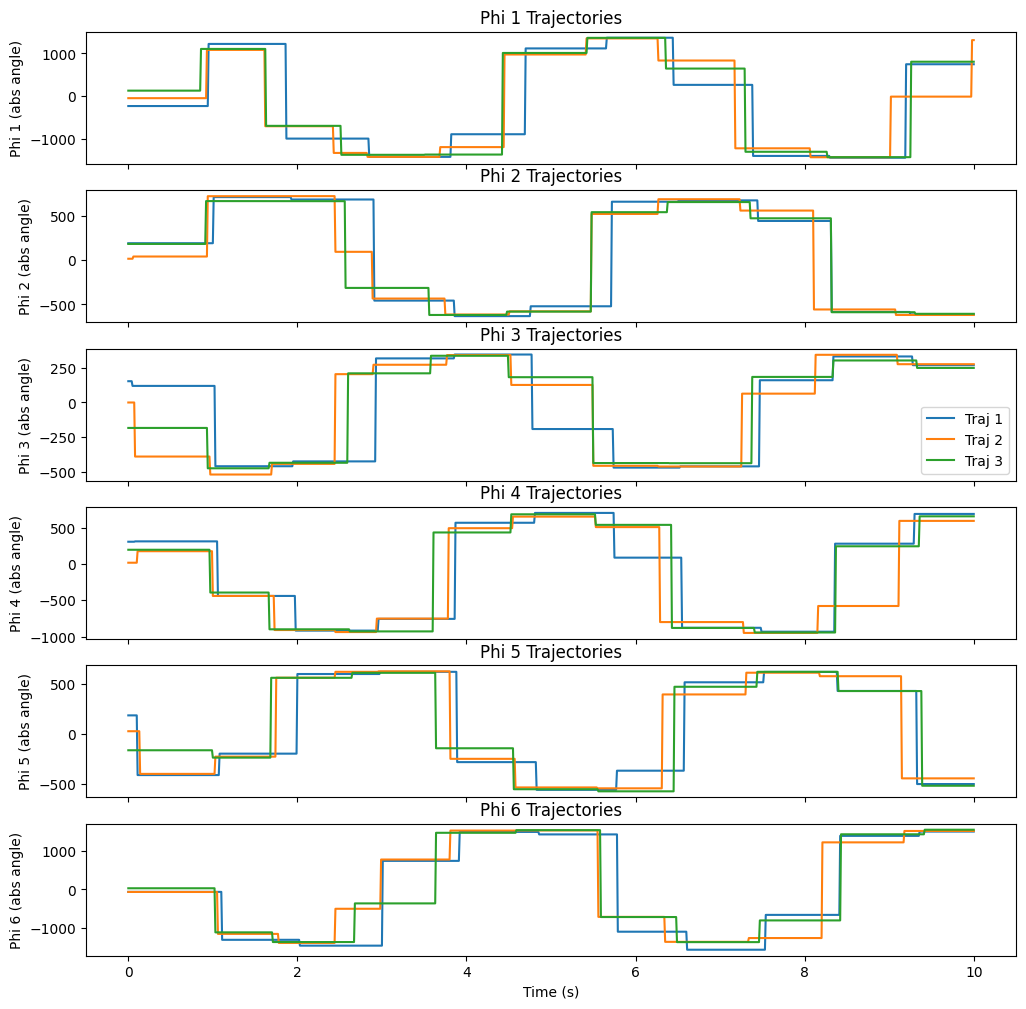

In [26]:
fig, axs = plt.subplots(6, 1, figsize=(12,12), sharex=True)
time = ys_ik['ID']/100 # time in s

# Plot phi1
axs[0].plot(time, ys_ik['phi1'], label='Traj 1')
axs[0].plot(time, ys_ik_2['phi1'], label='Traj 2')
axs[0].plot(time, ys_ik_3['phi1'], label='Traj 3')
axs[0].set_title("Phi 1 Trajectories")
axs[0].set_ylabel("Phi 1 (abs angle)")

# Plot phi2
axs[1].plot(time, ys_ik['phi2'], label='Traj 1')
axs[1].plot(time, ys_ik_2['phi2'], label='Traj 2')
axs[1].plot(time, ys_ik_3['phi2'], label='Traj 3')
axs[1].set_title("Phi 2 Trajectories")
axs[1].set_ylabel("Phi 2 (abs angle)")

# Plot phi3
axs[2].plot(time, ys_ik['phi3'], label='Traj 1')
axs[2].plot(time, ys_ik_2['phi3'], label='Traj 2')
axs[2].plot(time, ys_ik_3['phi3'], label='Traj 3')
axs[2].set_title("Phi 3 Trajectories")
axs[2].set_ylabel("Phi 3 (abs angle)")

# Plot phi4
axs[3].plot(time, ys_ik['phi4'], label='Traj 1')
axs[3].plot(time, ys_ik_2['phi4'], label='Traj 2')
axs[3].plot(time, ys_ik_3['phi4'], label='Traj 3')
axs[3].set_title("Phi 4 Trajectories")
axs[3].set_ylabel("Phi 4 (abs angle)")

# Plot phi5
axs[4].plot(time, ys_ik['phi5'], label='Traj 1')
axs[4].plot(time, ys_ik_2['phi5'], label='Traj 2')
axs[4].plot(time, ys_ik_3['phi5'], label='Traj 3')
axs[4].set_title("Phi 5 Trajectories")
axs[4].set_ylabel("Phi 5 (abs angle)")

# Plot phi6
axs[5].plot(time, ys_ik['phi6'], label='Traj 1')
axs[5].plot(time, ys_ik_2['phi6'], label='Traj 2')
axs[5].plot(time, ys_ik_3['phi6'], label='Traj 3')
axs[5].set_title("Phi 6 Trajectories")
axs[5].set_ylabel("Phi 6 (abs angle)")
axs[5].set_xlabel("Time (s)")



axs[2].legend(loc="lower right")

flip control inputs to see if the data is hysteretic

In [34]:
def flip_csv_data(input_file, output_file):
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(input_file)
    
    # Separate the 'ID' column from the rest of the DataFrame
    id_column = df['ID']
    data_columns = df.drop(columns=['ID'])
    
    # Flip the rows of the data columns
    flipped_data = data_columns.iloc[::-1].reset_index(drop=True)
    
    # Recombine the 'ID' column with the flipped data
    flipped_df = pd.concat([id_column, flipped_data], axis=1)
    
    # Save the flipped DataFrame back to a new CSV
    flipped_df.to_csv(output_file, index=False)

    print(f"Data has been flipped (except 'ID') and saved to {output_file}")

In [35]:
input_file = "../data/trajectories/dynamic/control_inputs_controlled_14.csv"
output_file = "../data/trajectories/dynamic/control_inputs_controlled_15.csv"
flip_csv_data(input_file, output_file)

Data has been flipped (except 'ID') and saved to ../data/trajectories/dynamic/control_inputs_controlled_15.csv
